In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
# os.path.dirname(sys.executable)
# sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [3]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.ssupervae import SSuperVAE
from networks.ssuper_global_local_discriminating import SSuperGlobalLocalDiscriminating
from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

In [4]:
config = read_config(Config.SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)
disc_config = read_config(Config.GLOBAL_LOCAL_DISC)
ptu.set_gpu_mode(True)

In [5]:
base_net = SSuperVAE(config.backbone,
                         latent_dim=config.latent_dim,
                         embed_dim=config.embed_dim,
                         use_lstm=config.use_lstm,
                         seq_size=config.seq_size,
                         decoder_channels=config.decoder_channels,
                         gen_img_size=config.image_dim,
                         lstm_hidden=config.lstm_hidden,
                         lstm_dropout=config.lstm_dropout,
                         fc_hidden_dims=config.fc_hidden_dims,
                         fc_dropout=config.fc_dropout,
                         num_lstm_layers=config.num_lstm_layers,
                         masked_first=config.masked_first).cuda()

net = SSuperGlobalLocalDiscriminating(base_net,
                                                        # Assuming that panels are square
                                                        panel_img_size=golden_age_config.panel_dim[0],
                                                        output_img_size=config.image_dim).cuda()

if config.parallel == True:
        net = nn.DataParallel(net)

load_path = "/scratch/users/gsoykan20/projects/AF-GAN/playground/ssuper_global_local_discriminating/ckpts/27-05-2021-12-06-08_model-checkpoint-epoch75.pth"
net.load_state_dict(torch.load(load_path)['model_state_dict'])
net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [31]:
pnet = SSuperVAE(config.backbone, 
                latent_dim=config.latent_dim, 
                embed_dim=config.embed_dim,
                use_lstm=False,
                seq_size=config.seq_size,
                decoder_channels=config.decoder_channels,
                gen_img_size=config.image_dim,
                lstm_hidden=config.lstm_hidden,
                lstm_dropout=config.lstm_dropout,
                fc_hidden_dims=config.fc_hidden_dims,
                fc_dropout=config.fc_dropout,
                num_lstm_layers=config.num_lstm_layers,
                masked_first=config.masked_first).cuda() 

l_path = "/userfiles/comics_grp/pretrained_models/plain_ssupervae_epoch85.pth"
pnet.load_state_dict(torch.load(l_path)['model_state_dict'])
pnet = pnet.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [6]:
dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              golden_age_config.panel_dim,
                              config.image_dim, 
                              augment=False, 
                              shuffle=False,
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=-1)

data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [7]:
dl_iter = iter(data_loader)

## Masking Test

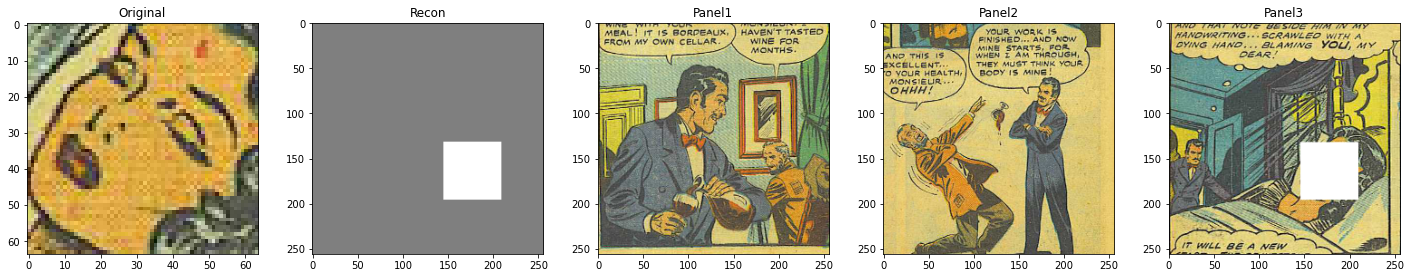

In [8]:
x, y, z = next(dl_iter)
plot_panels_and_faces(x, y, z.unsqueeze(0).repeat(1, 3, 1, 1))

## Model Result Test

[INFO] Example: 0


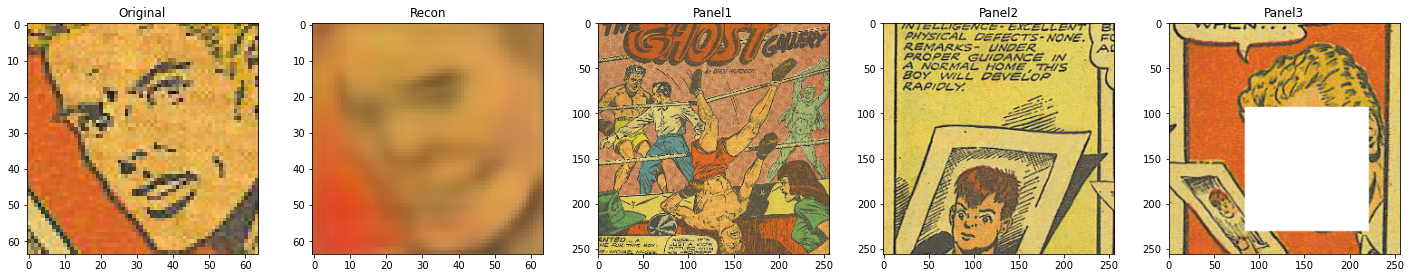

[INFO] Example: 1


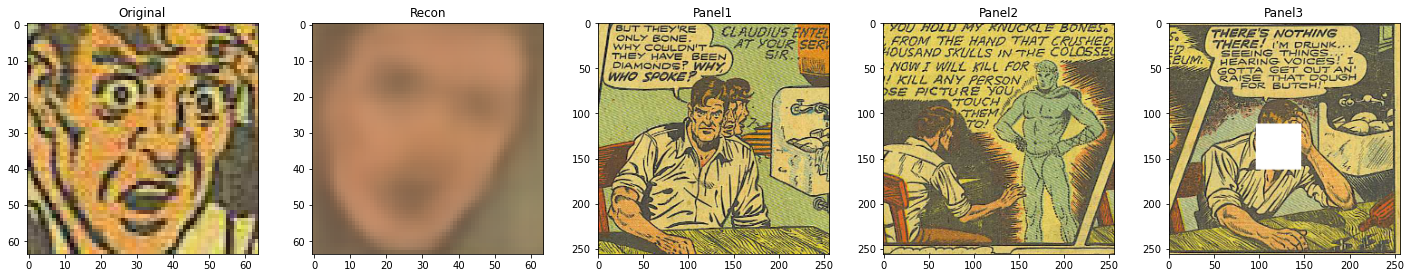

[INFO] Example: 2


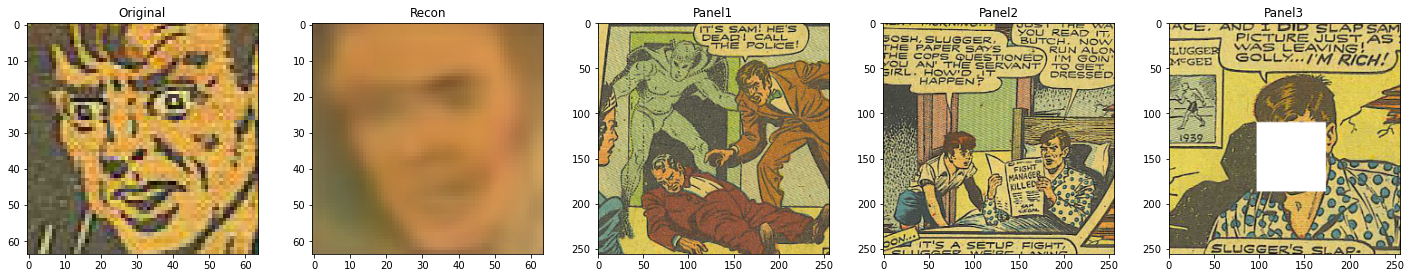

In [13]:
ctr, limit = 0, 3

for i in range(limit):
    x, y, z = next(dl_iter)
    
    with torch.no_grad():
        _, _, _, y_recon, _ = net(x=x.cuda())   
      #   _, _, _, py_recon, _ = pnet(x.cuda()) 
    print("[INFO] Example:", i)
    plot_panels_and_faces(x, y, y_recon.cpu())
    # plot_panels_and_faces(x, y, py_recon.cpu())

TypeError: forward() takes 1 positional argument but 2 were given

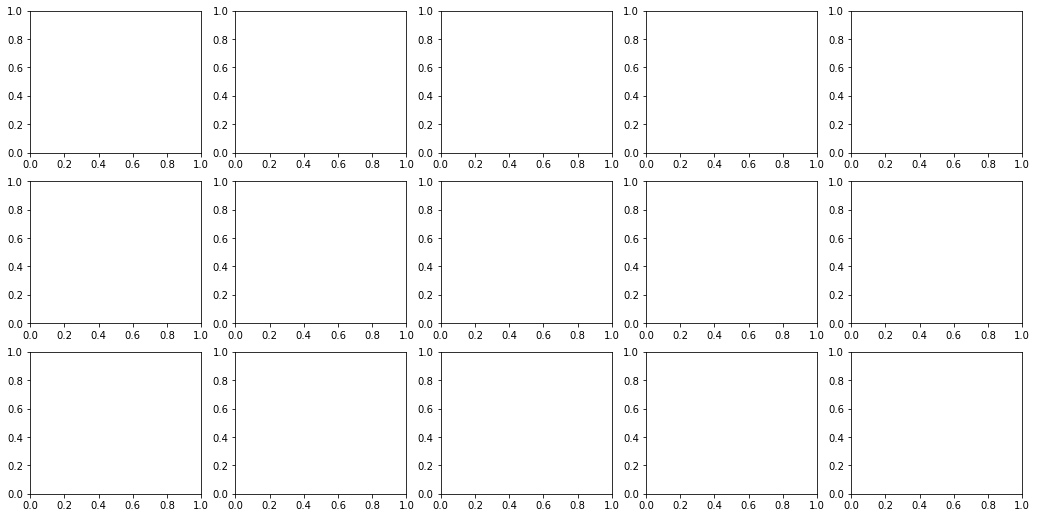

In [25]:
import copy

#net.generator.encoder.lstm.train()

x, y, z = next(dl_iter)

draw_saliency(net, copy.deepcopy(x), copy.deepcopy(y))
# draw_saliency(pnet, copy.deepcopy(x), copy.deepcopy(y))

draw_backbone_saliency(net.module.encoder.embedder, copy.deepcopy(x), 0)
# draw_backbone_saliency(pnet.encoder.embedder, copy.deepcopy(x), 0)

draw_backbone_saliency(net.module.encoder.embedder, copy.deepcopy(x), 1)
# draw_backbone_saliency(pnet.encoder.embedder, copy.deepcopy(x), 1)

#net.generator.encoder.lstm.eval()

In [7]:
import torch
import torch.nn.functional as F

def kl_loss_old(z, mu, std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)
    log_q = q.log_prob(z)
    log_p = p.log_prob(z)
    return F.kl_div(log_p, log_q, reduction="batchmean", log_target=True)


def kl_loss_new(z, mu, std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    kl_dvergence = torch.distributions.kl.kl_divergence(q,p)
    kl_loss = kl_dvergence.sum(1).mean()
    return kl_loss

In [8]:
z = torch.randn(1, 256)
mu = torch.randn(1, 256)
std = torch.randn(1, 256).exp()

print(kl_loss_old(z, mu, std))
print(kl_loss_new(z, mu, std))

tensor(15.4770)
tensor(1199.8945)
